# Redes Neurais para Previsão de Trajetória

Neste notebook, usaremos redes neurais para previsão de trajetória futura de uma tempestade. A ideia geral é dado as informações de um furacão de algumas horas atrás e do presente, projetaremos a sua posição futura. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
# from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
import tensorflow as tf

tf.keras.backend.clear_session()  

print(tf.__version__)

2.0.0


## Preparação dos dados

Iremos abaixo criar funções para preparar nossos dados para o modelo, e aplicá-las ao dataframe original

In [3]:
#Leitura dos dados
data = pd.read_csv('Datasets/data_atl_merged2.csv',parse_dates=['Date'])
data.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Year',
       'Month', 'Day', 'Latitude_c', 'Longitude_c', 'Duration', 'sst', 'rhum',
       'wspd', 'slp', 'cldc'],
      dtype='object')

In [34]:
## Funções de Padronização:

def standard_scale(data,cols):
    df = data.copy()
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        df.loc[:,col] = (df[col]-mean)/std
    return df[cols]
def standard_scale_back(scaled,original,cols):
    df = scaled.copy()
    for col in cols:
        mean = original[col].mean()
        std = original[col].std()
        df.loc[:,col] = df[col]*std+mean
    return df[cols]

In [35]:
# Função que divide os dados por ID da tempestade
def split(df):
    st = []
    ids = df.ID.unique()
    for ID in ids:
        st.append(df[df.ID==ID])
    return st
splitted = split(data)
print(len(splitted))

685


A função "clean_data" formata o preditor Tempo, o convertendo para horas (por padrão, horas após Jan/1951), e padroniza os dados de input.

A função "shift_data", faz um shift dos dados e dá como saída as matriz tridimensional X e o vetor Y, onde X é composto por matrizes $s\times n$:

$$\left[\begin{matrix}
x_1^{(t-s+1)} & x_2^{(t-s+1)} & ...& x_n^{(t-s+1)}\\
x_1^{(t-s+2)} & x_2^{(t-s+2)} & ...& x_n^{(t-s+2)}\\
\vdots &\vdots &\vdots &\vdots\\
x_1^{(t)} & x_2^{(t)} & ...& x_n^{(t)}\end{matrix}\right]$$

na qual:

- $x_1,~x_2, ~..., ~x_n$ representam os $n$ preditores usados (Usaremos 4 inicialmente: tempo latitude, longitude e velocidade de vento)

- $x_i^{(k)}$ representa o preditor $i$ no registro de tempo $k$. 

- $s$ é o parâmetros "shift", que representa em quantos períodos passados basearemos a previsão futura. Por padrão, inicialmente, deixamos $s=3$. Como cada registro é espaçado por 6 horas, neste formado estamos usando daados do presente e de 12 horas atrás, pra projetar o dado futuro.

O vetor $Y$ é composto por:

$$\left[\begin{matrix}lat^{(t+1)}&lon^{(t+1)}\\
lat^{(t+2)}&lon^{(t+2)}\\
\vdots & \vdots\\
lat^{(t+p)}&lon^{(t+p)}\end{matrix}\right]$$

na qual:

- $lat^{(k)}$ e $lon^{(k)}$ representam latitude e longitude no registro de tempo $k$
- $p$ é o parâmetro "pred", que diz quantos períodos à frente iremos prever. Por padrão, deixamos $p=1$, assim a matriz se resume em um vetor $[lat^{(t+1)},~ lon^{(t+1)}]$. Usamos previsões de 3 registros passados para prever o próximo registro após o último ponto de treino. Um trabalho futuro seria usar intervalos de previsões maiores, mas vamos nos ater aqui a apenas 1 registro à frete, o que equivale a 6 horas na grande maiorias dos pontos.



In [87]:
cols1 = ['Hours','Latitude','Longitude','Maximum Wind']
data.loc[:,'Time_new']=data.Date+data.Time.map(lambda x: pd.Timedelta(hours=x/100))

def clean_data(df,input_cols = cols1, year0 = 1951):
    df2 = df.copy()
    df2.loc[:,'Hours'] = (df2.loc[:,'Time_new']-pd.Timestamp(year0,1,1))/pd.Timedelta('1 hour')
    df2.loc[:,input_cols] = standard_scale(df2,input_cols)
    return df2[['ID']+input_cols]

def shift_data(df,shift = 3,pred = 1):

    x = []
    y = []
    df = df.set_index(np.arange(0,len(df)))
    for i in range(0,len(df)-shift):
        x_arr = []
        for j in range(i,i+shift):
            x_arr.append(df.loc[j,:])
        if pred == 1:
            y.append(np.array(df.loc[i+shift:i+shift+pred-1,['Latitude','Longitude']]).ravel())
        else:
            y.append(np.array(df.loc[i+shift:i+shift+pred-1,['Latitude','Longitude']]))
        x.append(np.array(x_arr))
       
    return np.array(x),np.array(y)

In [88]:
data_cleaned = clean_data(data)
data_cleaned.describe()

,Hours,Latitude,Longitude,Maximum Wind
count,2.238600e+04,2.238600e+04,2.238600e+04,2.238600e+04
mean,-1.312271e-17,3.398752e-15,4.449279e-15,5.249630e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.823465e+00,-1.939104e+00,-2.303286e+00,-1.644750e+00
25%,-8.725997e-01,-8.005268e-01,-7.741070e-01,-8.529203e-01
50%,1.595638e-01,-4.466462e-02,-5.884587e-02,-2.590479e-01
75%,9.229854e-01,6.250867e-01,7.057436e-01,5.327820e-01
max,1.499554e+00,5.121988e+00,6.195990e+00,4.491932e+00


### Treino, Validação e Teste

Para formatar os dados de treino, teste e validação, primeiramente, usamos a função "split", que separa os dados em uma lista de dataframes onde cada um deles representa uma tempestade diferente.

Após isso atribuimos 70% da lista para treino, 20% para validação e 10% para teste. Cada dataframe é devidamente formatado para as matrizes acima usando a função "shift_data", e após isso, unimos as matrizes de saída para gerar a numpy array final, do modelo.

Se fizéssemos o split diretamente, esse tipo de erro poderia acontecer. Suponha que uma tempestade tem seu último registro em 20 de Agosto em um determinado local, e uma outra tempestade se inicial dia 21 de Agosto em um local totalmente diferente. Um split direto poderia usar o registro de 20 de Agosto para prever o do dia 21, sendo que não há relação entre eles.

Essa separação por tempestade é importante para garantir a integridade dos nossos dados de modelagem, de forma que o treinamento seja feito tempestade por tempestade.

In [89]:
def train_val_test_split(df,t=0.7,v=0.2,input_cols=cols1,shift=3,pred=1):
    # t = fração de treino
    # v = fração de validação
    # fração de teste = 1-t-v
    # df = dataset já limpo por clean_data
    splitted_data = split(df)
    # Separamos os dados tempestade por tempestade para 
    # evitar cruzamento de dados entre eventos diferentes
    n = len(splitted)
    
    train_storms = splitted_data[0:int(n*t)]
    val_storms = splitted_data[int(n*t):int(n*(t+v))]
    test_storms = splitted_data[int(n*(1-t-v)):]
    
    #Geramos uma lista de matrizes, onde cada lista se refere 
    #aos dados descocados de uma tempestade diferente
    xy_train = [shift_data(train[input_cols],shift,pred) for train in train_storms]
    xy_val = [shift_data(val[input_cols],shift,pred) for val in val_storms]
    xy_test = [shift_data(test[input_cols],shift,pred) for test in test_storms]
    
    # Concatenação das matrizes para gerar os dados finais
    xtrain = np.concatenate([x[0] for x in xy_train],axis=0)
    ytrain = np.concatenate([y[1] for y in xy_train],axis=0)

    xval = np.concatenate([x[0] for x in xy_val],axis=0)
    yval = np.concatenate([y[1] for y in xy_val],axis=0)

    xtest = np.concatenate([x[0] for x in xy_test],axis=0)
    ytest = np.concatenate([y[1] for y in xy_test],axis=0)
    
    return xtrain, ytrain, xval, yval, xtest, ytest

In [90]:
%%time
#O processo de split pode ser lento à depender de seu computador
xtrain, ytrain, xval, yval, xtest, ytest = train_val_test_split(data_cleaned)

xtrain.shape,ytrain.shape,xval.shape,yval.shape,xtest.shape,ytest.shape

CPU times: user 1min 1s, sys: 363 ms, total: 1min 2s
Wall time: 1min 1s


((14010, 3, 4), (14010, 2), (4401, 3, 4), (4401, 2), (18482, 3, 4), (18482, 2))

In [94]:
%%time
## Modelo que usa sst, rhum e slp (Temperatura do mar, Umidade e Pressão)
cols2 = input_cols +['sst','rhum','slp','cldc']
cleaned2 = clean_data(data,cols2)

xtrain2, ytrain2, xval2, yval2, xtest2, ytest2 = train_val_test_split(cleaned2,input_cols=cols2)

CPU times: user 1min 32s, sys: 470 ms, total: 1min 32s
Wall time: 1min 31s


In [93]:
xtrain2.shape

(14010, 3, 7)

## Modelos - Redes Neurais

Vamos criar alguns modelos determinísticos e depois comparar a médias dos erros ao quadrado (MSE) nos dados de validação e teste. (Uma espécie de cross-validation).

Segundo os artigos na qual usamos como referência (Veja Bibliografia), apenas uma camada interna é suficiente. Resta saber quantos neurônios usar, para isso avaliaremos os modelos com 3, 6, e 9 neurônios internos.

Usaremos a função de ativação sigmoid na camada interna. e linear na camada de output, já que os dados de saída são numéricos contínuos. Usamos também uma camada de dropout de 15% para evitar overfitting.

Após eleger o melhor, incluiremos um fator probabilístico para gerar intervalos de confianças nas predições.

__Índice de Modelos__

- _Model_ihj_  --> Modelo com entrada de $i$ variáveis, $h$ neurônios na camada interna e $j$ pontos de saída (no nosso caso $j=2$ sempre)

- _Model_4h2_ --> Modelo que usa as variáveis Tempo, Latitude, Longitude e Velocidame Máxima de Vento (4 variáveis) de três registros passados para prever a Latitude e Longitude do próximo registro (2 saídas) usando $h$ neurônios na camada interna. Aqui geraremos 3 modelos para os valores de h sendo 3, 6 e 9.

- _Model_8h2_ --> Modelo similar ao anterior, porém utiliza quatro variáveis a mais como entrada: sst, rhum, slp, cldc; Representando Temperatura a nível do mar, Umidade, Pressão a nível do mar e Cobertura de Nuvens.

In [95]:
# Modelos tipo 4h2
model_432 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,4)),
  tf.keras.layers.Dense(3, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])

model_462 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,4)),
  tf.keras.layers.Dense(6, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])

model_492 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,4)),
  tf.keras.layers.Dense(9, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])


In [96]:
# Modelos tipo 8h2
model_832 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,8)),
  tf.keras.layers.Dense(3, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])

model_862 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,8)),
  tf.keras.layers.Dense(6, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])

model_892 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,8)),
  tf.keras.layers.Dense(9, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])


In [98]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

model_432.compile(optimizer=optimizer,
              loss=loss_fn)
model_462.compile(optimizer=optimizer,
              loss=loss_fn)
model_492.compile(optimizer=optimizer,
              loss=loss_fn)
model_832.compile(optimizer=optimizer,
              loss=loss_fn)
model_862.compile(optimizer=optimizer,
              loss=loss_fn)
model_892.compile(optimizer=optimizer,
              loss=loss_fn)
model_432.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 39        
_________________________________________________________________
dropout_6 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 8         
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


In [143]:
%%time

history_432 = model_432.fit(xtrain, ytrain, validation_data=(xval,yval), epochs=45, 
                    verbose=0)
history_462 = model_462.fit(xtrain, ytrain, validation_data=(xval,yval), epochs=45, 
                    verbose=0)
history_492 = model_492.fit(xtrain, ytrain, validation_data=(xval,yval), epochs=45, 
                    verbose=1)


Train on 14010 samples, validate on 4401 samples
Epoch 1/45
14010/14010 [==============================] - 1s 80us/sample - loss: 0.0757 - val_loss: 0.0101
Epoch 2/45
14010/14010 [==============================] - 1s 77us/sample - loss: 0.0779 - val_loss: 0.0099
Epoch 3/45
14010/14010 [==============================] - 1s 92us/sample - loss: 0.0779 - val_loss: 0.0109
Epoch 4/45
14010/14010 [==============================] - 2s 121us/sample - loss: 0.0760 - val_loss: 0.0100
Epoch 5/45
14010/14010 [==============================] - 2s 111us/sample - loss: 0.0767 - val_loss: 0.0096
Epoch 6/45
14010/14010 [==============================] - 2s 152us/sample - loss: 0.0742 - val_loss: 0.0121
Epoch 7/45
14010/14010 [==============================] - 1s 90us/sample - loss: 0.0766 - val_loss: 0.0119
Epoch 8/45
14010/14010 [==============================] - 1s 73us/sample - loss: 0.0758 - val_loss: 0.0108
Epoch 9/45
14010/14010 [==============================] - 1s 71us/sample - loss: 0.0779 - va

In [101]:
%%time

history_832 = model_832.fit(xtrain2, ytrain2, validation_data=(xval2,yval2), epochs=45, 
                    verbose=0)
history_862 = model_862.fit(xtrain2, ytrain2, validation_data=(xval2,yval2), epochs=45, 
                    verbose=0)
history_892 = model_892.fit(xtrain2, ytrain2, validation_data=(xval2,yval2), epochs=45, 
                    verbose=1)

Train on 14010 samples, validate on 4401 samples
Epoch 1/45
14010/14010 [==============================] - 2s 111us/sample - loss: 0.3210 - val_loss: 0.0874
Epoch 2/45
14010/14010 [==============================] - 1s 58us/sample - loss: 0.1670 - val_loss: 0.0666
Epoch 3/45
14010/14010 [==============================] - 1s 61us/sample - loss: 0.1460 - val_loss: 0.0563
Epoch 4/45
14010/14010 [==============================] - 1s 61us/sample - loss: 0.1326 - val_loss: 0.0473
Epoch 5/45
14010/14010 [==============================] - 1s 66us/sample - loss: 0.1232 - val_loss: 0.0398
Epoch 6/45
14010/14010 [==============================] - 1s 61us/sample - loss: 0.1170 - val_loss: 0.0334
Epoch 7/45
14010/14010 [==============================] - 1s 59us/sample - loss: 0.1055 - val_loss: 0.0274
Epoch 8/45
14010/14010 [==============================] - 1s 62us/sample - loss: 0.1025 - val_loss: 0.0236
Epoch 9/45
14010/14010 [==============================] - 1s 60us/sample - loss: 0.0974 - val_

In [104]:
# Salvando os modelos para uso futuro
model_432.save('Saved_NN_Models/model_432.h5')
model_462.save('Saved_NN_Models/model_462.h5')
model_492.save('Saved_NN_Models/model_492.h5')
model_832.save('Saved_NN_Models/model_832.h5')
model_862.save('Saved_NN_Models/model_862.h5')
model_892.save('Saved_NN_Models/model_892.h5')

# Recreando os modelos dos arquivos salvos
# model_432 = tf.keras.models.load_model('Saved_NN_Models/model_432.h5')
# model_462 = tf.keras.models.load_model('Saved_NN_Models/model_462.h5')
# model_492 = tf.keras.models.load_model('Saved_NN_Models/model_492.h5')
# model_832 = tf.keras.models.load_model('Saved_NN_Models/model_832.h5')
# model_862 = tf.keras.models.load_model('Saved_NN_Models/model_862.h5')
# model_892 = tf.keras.models.load_model('Saved_NN_Models/model_892.h5')

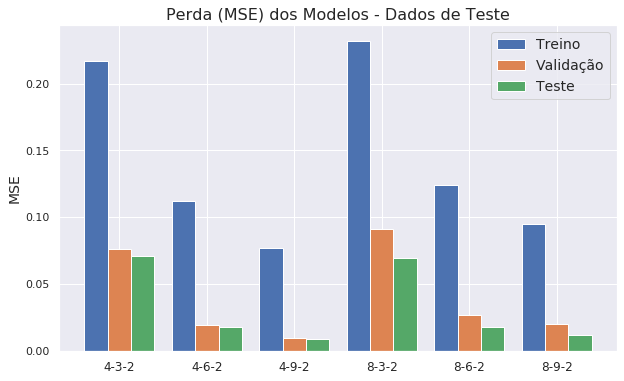

In [154]:
models4 = [model_432,model_462,model_492]
models8 = [model_832,model_862,model_892]
history_list = [history_432,history_462,history_492,history_832,history_862,history_892]

labels = ["4-3-2",'4-6-2','4-9-2',"8-3-2",'8-6-2','8-9-2']
fig,ax = plt.subplots(1,1,figsize=(10,6))

test_mse = []
train_mse = []
val_mse = []
for model in models4:
    test_mse.append(model.evaluate(xtest,ytest,verbose=0))
for model in models8:
    test_mse.append(model.evaluate(xtest2,ytest2,verbose=0))
for history in history_list:
    train_mse.append(np.mean(history.history['loss']))
    val_mse.append(np.mean(history.history['val_loss']))
wid = 0.8/3-0.0001
ax.set_title("Perda (MSE) dos Modelos - Dados de Teste",fontsize=16)
ax.set_ylabel("MSE",fontsize=14)
ax.bar(np.arange(0,6)-wid,train_mse,label="Treino",width = wid)
ax.bar(np.arange(0,6),val_mse,label='Validação',width = wid)
ax.bar(np.arange(0,6)+wid,test_mse,label = "Teste",width = wid)
ax.set_xticklabels(['0']+labels,fontsize=12)
ax.legend(loc='best',fontsize=14);
plt.savefig('figs/NN_Models_MSE.jpg')


Vemos que os modelos 4-9-2 e 8-9-2 performaram melhor em todos os conjuntos de dados. Vemos que 9 neurônios internos performam muito bem. Vamos trabalhar com esses modelos a partir daqui. Em especial, com o 8-9-2 que apesar de ter uma maior perda do que o 4-9-2, ele utiliza uma maior quantidade de informações climáticas.

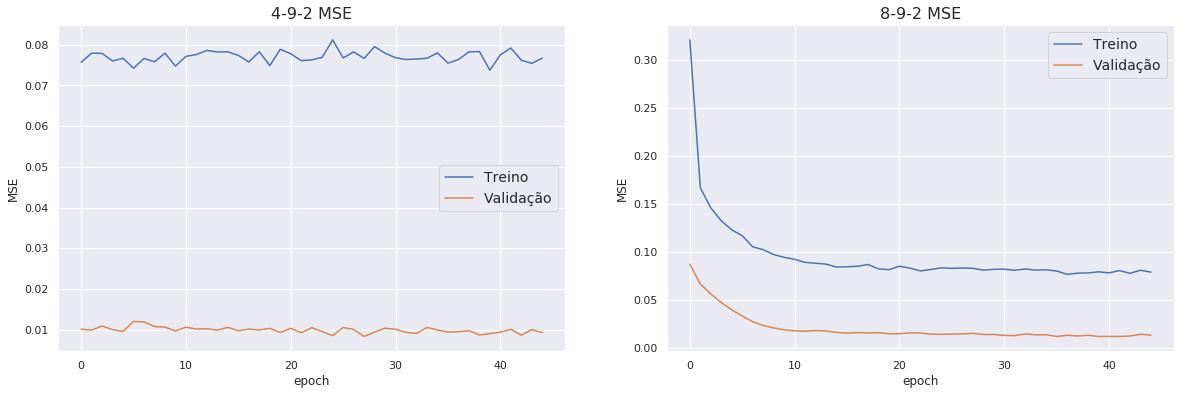

In [155]:
# plot accuracy and loss for the test set
fig, (ax,ax1) = plt.subplots(1,2, figsize=(20,6))

ax.plot(history_492.history['loss'])
ax.plot(history_492.history['val_loss'])
ax.set_title('4-9-2 MSE',fontsize=16)
ax.set_ylabel('MSE')
ax.set_xlabel('epoch')
ax.legend(['Treino', 'Validação'], fontsize=14,loc='best')
ax1.plot(history_892.history['loss'])
ax1.plot(history_892.history['val_loss'])
ax1.set_title('8-9-2 MSE',fontsize = 16)
ax1.set_ylabel('MSE')
ax1.set_xlabel('epoch')
ax1.legend(['Treino', 'Validação'], fontsize=14,loc='best');
plt.savefig('figs/MSE-epoch.jpg')

R2 Latitude Teste - 0.988149240276217
R2 Longitude Teste - 0.9864725794069319
R2 Total Teste - 0.9873109098415744


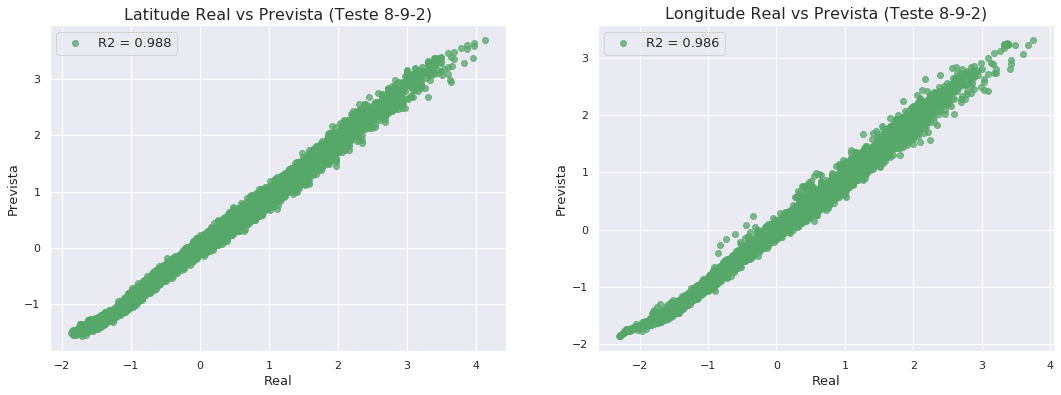

In [170]:
from sklearn.metrics import r2_score
ypred = model_892.predict(xtest2)
# from sklearn.linear_model import LinearRegression
# lr = LinearRegression().fit(ytest,ypred)
# lr.score(ytest,ypred)
lat_r2 = r2_score(ytest2[:,0],ypred[:,0])
lon_r2 = r2_score(ytest2[:,1],ypred[:,1])
tot_r2 = r2_score(ytest2,ypred)
print(f"R2 Latitude Teste - {lat_r2}")
print(f"R2 Longitude Teste - {lon_r2}")
print(f"R2 Total Teste - {tot_r2}")

fig, (ax,ax1) = plt.subplots(1,2,figsize=(18,6))
ax.set_title("Latitude Real vs Prevista (Teste 8-9-2)",fontsize=16)
ax.set_xlabel("Real",fontsize = 13)
ax.set_ylabel("Prevista",fontsize = 13)
ax.scatter(ytest2[:,0],ypred[:,0],alpha = 0.75, color = 'g',label = f"R2 = {round(lat_r2,3)}")
ax.legend(loc='best', fontsize = 13)
ax1.set_title("Longitude Real vs Prevista (Teste 8-9-2)",fontsize=16)
ax1.set_xlabel("Real",fontsize = 13)
ax1.set_ylabel("Prevista",fontsize = 13)
ax1.scatter(ytest2[:,1],ypred[:,1],alpha = 0.75, color = 'g',label = f"R2 = {round(lon_r2,3)}")
ax1.legend(loc='best', fontsize = 13);
plt.savefig('figs/lat_lon_teste.jpg')

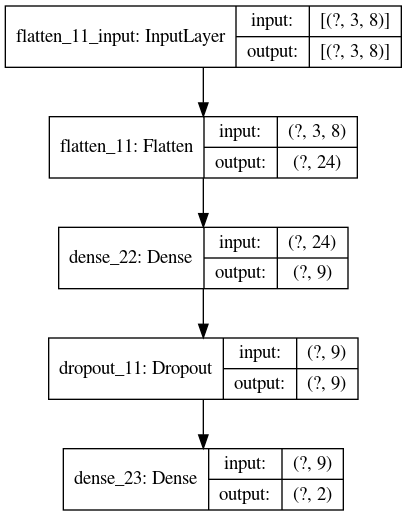

In [176]:
tf.keras.utils.plot_model(
    model_892,
    to_file='figs/model_892.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)
# plt.savefig('figs/model892.jpg')

In [161]:
data_test = data.loc[int(n*0.9):,:]
data_test.loc[:,'Hours'] = (data_test.loc[:,'Time_new']-pd.Timestamp(1951,1,1))/pd.Timedelta('1 hour')
# data_test[data_test.Category=="Category 3"]
irene = data_test[data_test.ID=='AL092011']
irene.loc[:,cols2]=standard_scale(irene,cols2)
ir = irene.loc[:,cols2]

def predict(storm,model,shift=3,pred=1):
    storm = storm.set_index(np.arange(0,len(storm)))
    y_pred=[]
    for i in range(0,len(storm)-shift-1):
        x = []
        for j in range(i,i+shift):
            x.append(storm.loc[j,:])
#         if i == 0:
#             print(np.expand_dims(np.asarray(x), axis=0).shape)
#             print(np.expand_dims(np.asarray(x),axis=0)[0,0,0])
        y_pred.append(model.predict(np.expand_dims(np.asarray(x),axis=0)).ravel())
        del x
    return np.array(y_pred)
y_pred = predict(ir,model_892)
y_pred.shape

(39, 2)

0.9124620701244499
0.8651593770302984


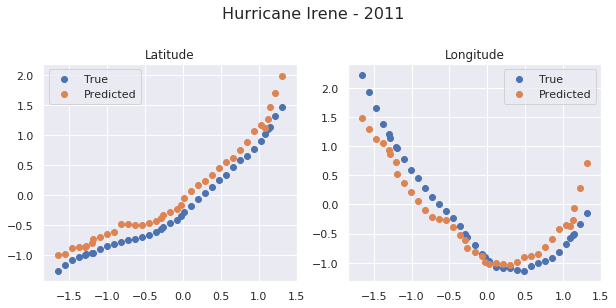

In [162]:
ir_plot = ir.iloc[0:-4,:]
fig,ax = plt.subplots(1,2,figsize=(10,4))
fig.suptitle("Hurricane Irene - 2011", fontsize=16,y=1.08)
ax[0].set_title("Latitude")
ax[1].set_title("Longitude")
print(r2_score(ir_plot.Latitude,y_pred[:,0]))
print(r2_score(ir_plot.Longitude,y_pred[:,1]))
ax[0].scatter(ir_plot.Hours,ir_plot.Latitude,label = 'True')
ax[0].scatter(ir_plot.Hours,y_pred[:,0],label = 'Predicted')
ax[1].scatter(ir_plot.Hours,ir_plot.Longitude,label = 'True')
ax[1].scatter(ir_plot.Hours,y_pred[:,1],label = 'Predicted')
ax[0].legend(loc='best')
ax[1].legend(loc='best')

In [165]:
# input_cols = ['Hours','Latitude','Longitude','Maximum Wind']
joaquin = data_test[data_test.ID=='AL112015']
joaquin.loc[:,cols2]=standard_scale(joaquin,cols2)
y_jq = predict(joaquin[cols2],model_892)

0.9645696502595049
0.9816239209481076


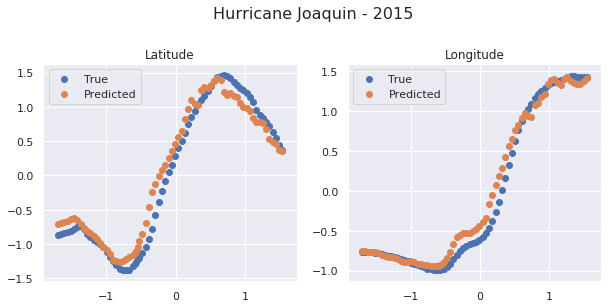

In [166]:
jq_plot = joaquin[input_cols].iloc[0:-4,:]
fig,ax = plt.subplots(1,2,figsize=(10,4))
fig.suptitle("Hurricane Joaquin - 2015", fontsize=16,y=1.08)
ax[0].set_title("Latitude")
ax[1].set_title("Longitude")
print(r2_score(jq_plot.Latitude,y_jq[:,0]))
print(r2_score(jq_plot.Longitude,y_jq[:,1]))
ax[0].scatter(jq_plot.Hours,jq_plot.Latitude,label = 'True')
ax[0].scatter(jq_plot.Hours,y_jq[:,0],label = 'Predicted')
ax[1].scatter(jq_plot.Hours,jq_plot.Longitude,label = 'True')
ax[1].scatter(jq_plot.Hours,y_jq[:,1],label = 'Predicted')
ax[0].legend(loc='best')
ax[1].legend(loc='best')